# Jupyter Notebook: Tính toán Chroma

Notebook này thực hiện tính toán đặc trưng Chroma từ một file âm thanh.

## Các bước thực hiện
1. **Đọc và xử lý tín hiệu âm thanh**: Đọc file WAV và chia thành các khung.
2. **Áp dụng cửa sổ Hamming**: Giảm hiệu ứng rìa khi tính FFT.
3. **Tính phổ năng lượng**: Sử dụng FFT để chuyển đổi tín hiệu sang miền tần số.
4. **Tính Chroma**: Ánh xạ phổ năng lượng vào 12 nốt nhạc (A, A#, ..., G#).
5. **Trực quan hóa**: Vẽ biểu đồ tín hiệu, heatmap Chroma, và biểu đồ cột cho vector trung bình.

In [1]:
# Import các thư viện cần thiết
import numpy as np
import librosa
import scipy.signal
import matplotlib.pyplot as plt

# Hàm tính Chroma cho một khung tín hiệu âm thanh

Hàm `chroma(signal, fs)` thực hiện tính toán đặc trưng **Chroma** cho một khung tín hiệu âm thanh, giúp biểu diễn năng lượng tín hiệu theo 12 nốt nhạc (12 bán cung trong một quãng tám).

1. **Chuẩn bị và ánh xạ tần số sang nốt nhạc:**
   - Biến `signal_len` lấy độ dài của khung tín hiệu.
   - Tính tần số của từng bin FFT dựa trên sampling rate `fs` và số điểm FFT (liên quan đến `signal_len`).
   - Ánh xạ các tần số này sang không gian log2, sau đó chuyển thành số thứ tự nốt nhạc (bán cung) bằng cách nhân với 12 và làm tròn. Kết quả là `num_chroma` cho biết mỗi bin FFT thuộc nốt nhạc nào.

2. **Tính số lượng bin FFT tương ứng với mỗi nốt nhạc:**
   - Với mỗi nốt nhạc duy nhất trong `num_chroma`, đếm số bin FFT ánh xạ vào nốt đó, lưu vào `num_f_chroma`.
   
3. **Tính năng lượng (cường độ) tín hiệu cho từng bin FFT:**
   - Bình phương biên độ tín hiệu tại từng bin để lấy năng lượng.
   - Chia năng lượng tại mỗi bin cho số lượng bin tương ứng của nốt nhạc để chuẩn hóa.

4. **Gộp năng lượng từ các bin thành 12 nốt nhạc:**
   - Mở rộng vector năng lượng `c` sao cho số phần tử chia hết cho 12 (để dễ reshape).
   - Chuyển đổi thành ma trận với 12 cột, mỗi cột tương ứng một nốt nhạc.
   - Tính tổng năng lượng cho từng cột, thu được vector 12 chiều là đặc trưng Chroma.

5. **Chuẩn hóa vector Chroma:**
   - Tổng năng lượng của khung tín hiệu được tính.
   - Chroma vector được chuẩn hóa bằng tổng năng lượng tín hiệu để giảm ảnh hưởng cường độ tín hiệu.
   - Tránh chia cho 0 bằng cách thay thế bằng một hằng số nhỏ nếu năng lượng bằng 0.


In [2]:
# Hàm tính Chroma cho một khung tín hiệu
def chroma(signal, fs):
    signal_len = len(signal)
    # Tính tần số của từng bin và ánh xạ sang nốt nhạc
    f = np.log2(
        np.array(
            [((1 + inx) * fs) / (27.5 * (2 * signal_len)) for inx in range(0, signal_len)]
        )
    )
    num_chroma = np.round(f * 12).astype(int)
    num_f_chroma = np.zeros((num_chroma.shape[0],))
    
    # Tổng hợp số bin cho từng nốt
    for n in np.unique(num_chroma):
        inx = np.nonzero(num_chroma == n)
        num_f_chroma[inx] = inx[0].shape

    # Tính năng lượng cho từng nốt
    if num_chroma.max() < num_chroma.shape[0]:
        c = np.zeros((num_chroma.shape[0],))
        c[num_chroma] = signal ** 2
        c = c / num_f_chroma[num_chroma]
    else:
        i = np.nonzero(num_chroma > num_chroma.shape[0])[0][0]
        c = np.zeros((num_chroma.shape[0],))
        c[num_chroma[0 : i - 1]] = signal ** 2
        c = c / num_f_chroma
    
    # Ánh xạ vào 12 nốt
    final_matrix = np.zeros((12, 1))
    d = int(np.ceil(c.shape[0] / 12.0) * 12)
    c2 = np.zeros((d,))
    c2[0 : c.shape[0]] = c
    c2 = c2.reshape(int(c2.shape[0] / 12), 12)
    final_matrix = np.sum(c2, axis=0).reshape(1, -1).T

    # Chuẩn hóa năng lượng
    signal_energy = np.sum(signal ** 2)
    if signal_energy == 0:
        return final_matrix / 1e-8
    return final_matrix / signal_energy

## Giải thích thuật toán của `chroma_function`

1. **Đọc và xử lý tín hiệu**:
   - Đọc file âm thanh với tần số lấy mẫu sr (16000 Hz mặc định).
   - Tính độ dài tín hiệu và số mẫu.

2. **Chia khung tín hiệu**:
   - Chia tín hiệu thành các khung với độ dài frame_length (25ms) và bước nhảy hop_length (10ms).
   - Số khung = ⌊(độ dài tín hiệu - độ dài khung) / bước nhảy⌋ + 1.

3. **Áp dụng cửa sổ Hamming**:
   - Nhân từng khung với cửa sổ Hamming để giảm hiệu ứng rìa khi tính FFT.

4. **Tính phổ năng lượng**:
   - Sử dụng rfft để chuyển đổi khung sang miền tần số, lấy độ lớn để tính năng lượng.

5. **Tính Chroma cho từng khung**:
   - Khởi tạo ma trận Chroma với kích thước (num_frames, 12).
   - Tính Chroma cho từng khung bằng hàm chroma.

6. **Tính trung bình Chroma**:
   - Lấy trung bình Chroma trên các khung không lặng (non_silent_indices).

7. **Chuẩn hóa Chroma**:
   - Chuẩn hóa bằng cách trừ trung bình và chia độ lệch chuẩn để tăng độ tương phản.

8. **Chuyển vị ma trận**:
   - Chuyển vị để phù hợp với heatmap (thời gian x nốt nhạc).

In [3]:
def chroma_function(file_path, sr=16000, frame_length=0.025, hop_length=0.010, nfft=2048):
    """
    Tính đặc trưng Chroma cho file âm thanh và trả về vector trung bình cùng ma trận Chroma.
    """
    # Đọc tín hiệu âm thanh
    y, sr = librosa.load(file_path, sr=sr)
    duration = len(y) / sr
    print(f"File âm thanh: {duration:.2f} giây, số mẫu: {len(y)}")

    # Chia khung
    frame_length_samples = int(frame_length * sr)
    hop_length_samples = int(hop_length * sr)
    frames = librosa.util.frame(y, frame_length=frame_length_samples, hop_length=hop_length_samples).T.copy()
    num_frames = frames.shape[0]
    print(f"Số khung: {num_frames}")

    # Áp dụng cửa sổ Hamming
    window = scipy.signal.get_window("hamming", frame_length_samples)
    frames *= window

    # Tính FFT magnitude
    fft_magnitude = np.abs(np.fft.rfft(frames, n=nfft, axis=1))

    # Tính Chroma cho tất cả khung
    n_chroma = 12
    chroma_features = np.zeros((num_frames, n_chroma))
    for i in range(num_frames):
        chroma_features[i, :] = chroma(fft_magnitude[i, :], sr).flatten()

    # Xác định các khung không lặng
    non_silent_indices = np.where(np.sum(fft_magnitude, axis=1) >= 1e-6)[0]
    print(f"Số khung không lặng: {len(non_silent_indices)}")

    # Chuẩn hóa Chroma về (-1, 1)
    chroma_features_normalized = np.zeros_like(chroma_features)
    if len(non_silent_indices) > 0:
        non_silent_chroma = chroma_features[non_silent_indices, :]
        
        # Tính min/max cho từng nốt Chroma (axis=0)
        min_vals = np.min(non_silent_chroma, axis=0, keepdims=True)
        max_vals = np.max(non_silent_chroma, axis=0, keepdims=True)
        ranges = max_vals - min_vals + 1e-8
        
        # Áp dụng min-max scaling
        normalized = 2 * (non_silent_chroma - min_vals) / ranges - 1
        normalized = np.clip(normalized, -1.0, 1.0)
        
        chroma_features_normalized[non_silent_indices, :] = normalized

    # Tính vector trung bình từ dữ liệu ĐÃ CHUẨN HÓA
    if len(non_silent_indices) > 0:
        chroma_mean = np.mean(chroma_features_normalized[non_silent_indices, :], axis=0)
    else:
        chroma_mean = np.zeros(n_chroma)

    # Chuyển vị ma trận
    return chroma_mean, chroma_features_normalized.T, chroma_features_normalized.T

## Giải thích thuật toán của `plot_chroma_heatmap`

- Sử dụng imshow để vẽ ma trận Chroma, với trục x là thời gian, trục y là nốt nhạc.
- Chuẩn hóa màu sắc bằng cmap='jet' và thêm colorbar để biểu diễn giá trị.
- Đặt nhãn trục x dựa trên thời gian (hop_length * số khung).
- Đặt nhãn trục y là 12 nốt nhạc (A đến G#).

In [4]:
# Hàm vẽ heatmap Chroma
def plot_chroma_heatmap(chroma_features, hop_length, sr, title="Hình. Minh họa Chroma"):
    plt.figure(figsize=(10, 4))
    plt.imshow(chroma_features, aspect='auto', origin='lower', cmap='jet', interpolation='nearest')
    plt.colorbar(label='Năng lượng Chroma')

    # Đặt nhãn trục x (Thời gian)
    num_frames = chroma_features.shape[1]
    time_axis = np.arange(num_frames) * hop_length
    plt.xticks(ticks=np.linspace(0, num_frames-1, 5), labels=np.round(np.linspace(0, time_axis[-1], 5), 2))
    plt.xlabel('Thời gian (s)')

    # Đặt nhãn trục y (Nốt nhạc)
    plt.ylabel('Nốt nhạc')
    plt.yticks(ticks=np.arange(12), labels=['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#'])
    plt.ylim(-0.5, 11.5)  # Đảm bảo hiển thị đầy đủ 12 nốt

    plt.title(title)
    plt.tight_layout()
    plt.show()

## Giải thích thuật toán của `plot_chroma_mean`

- Sử dụng bar để vẽ cột cho mỗi nốt nhạc (A đến G#).
- Đặt nhãn trục x là 12 nốt nhạc.
- Đặt nhãn trục y là năng lượng trung bình của từng nốt.
- Thêm lưới và tiêu đề để dễ quan sát.

In [5]:
# Hàm vẽ biểu đồ cột cho vector Chroma trung bình
def plot_chroma_mean(chroma_mean, title="Biểu đồ Vector Chroma Trung bình"):
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(chroma_mean)), chroma_mean, color='skyblue')
    plt.xlabel('Nốt nhạc')
    plt.ylabel('Năng lượng Chroma trung bình')
    plt.title(title)
    plt.xticks(range(len(chroma_mean)), ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#'])
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Giải thích thuật toán của `plot_signal`

- Vẽ tín hiệu theo thời gian (trục x) và biên độ (trục y).
- Chia trục x bằng tần số lấy mẫu (sr) để chuyển sang đơn vị giây.
- Thêm lưới và tiêu đề để dễ quan sát.

In [6]:
# Hàm vẽ tín hiệu âm thanh
def plot_signal(y, sr, title="Tín hiệu âm thanh"):
    plt.figure(figsize=(10, 3))
    plt.plot(np.arange(len(y)) / sr, y)
    plt.xlabel('Thời gian (s)')
    plt.ylabel('Biên độ')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Giải thích thuật toán của `test_chroma`

- Đọc file âm thanh và vẽ tín hiệu ban đầu.
- Tính Chroma bằng hàm chroma_function.
- In giá trị min, max và vector trung bình của Chroma.
- Vẽ heatmap và biểu đồ cột để trực quan hóa kết quả.

In [7]:
def test_chroma(file_path):
    """
    Hàm test Chroma với một file âm thanh.
    """
    try:
        # Đọc tín hiệu âm thanh để kiểm tra
        y, sr = librosa.load(file_path, sr=16000)
        plot_signal(y, sr)

        # Tính Chroma
        chroma_mean, chroma_features, chroma_features_normalized = chroma_function(file_path)

         # In giá trị Chroma đã chuẩn hóa
        print("Giá trị Chroma đã chuẩn hóa (min, max):", 
              np.min(chroma_features_normalized), 
              np.max(chroma_features_normalized))
        print("Vector Chroma trung bình (đã chuẩn hóa):", chroma_mean)

        # Vẽ heatmap Chroma (dùng bản đã chuẩn hóa để tăng độ tương phản)
        plot_chroma_heatmap(chroma_features_normalized, hop_length=0.010, sr=16000)

        # Vẽ biểu đồ cột cho vector Chroma trung bình
        plot_chroma_mean(chroma_mean)

    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file âm thanh '{file_path}'.")
    except Exception as e:
        print(f"Lỗi xảy ra: {str(e)}")

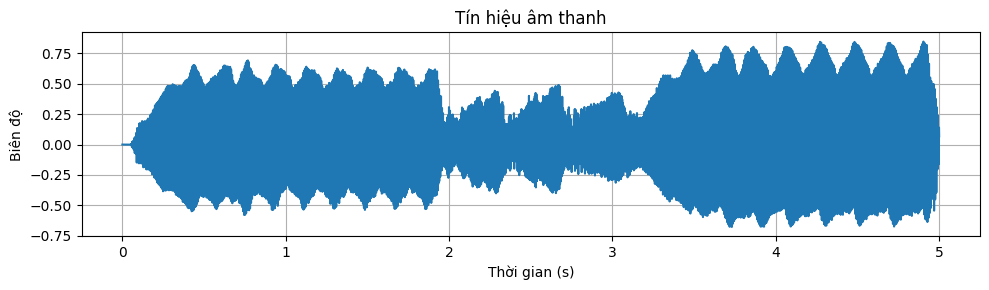

File âm thanh: 5.00 giây, số mẫu: 80000
Số khung: 498
Số khung không lặng: 496
Giá trị Chroma đã chuẩn hóa (min, max): -1.0 0.9999996806377076
Vector Chroma trung bình (đã chuẩn hóa): [-0.58916727 -0.49484339  0.01231039 -0.0985155  -0.12097659 -0.03651893
  0.23928001  0.4000046  -0.04169314 -0.24906722 -0.44574973 -0.57021622]


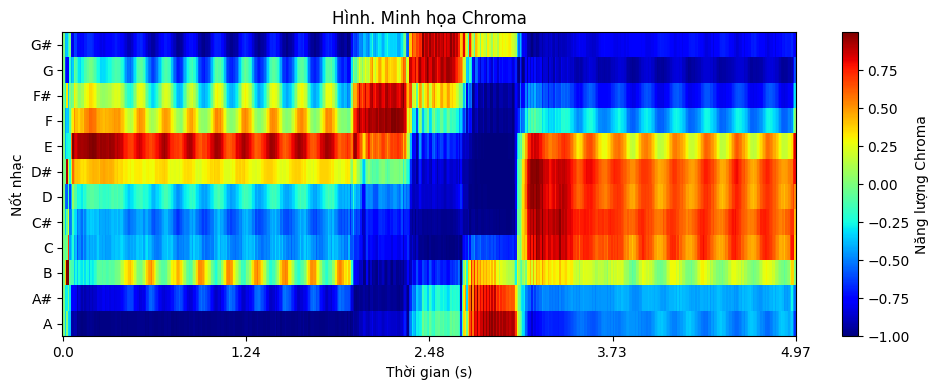

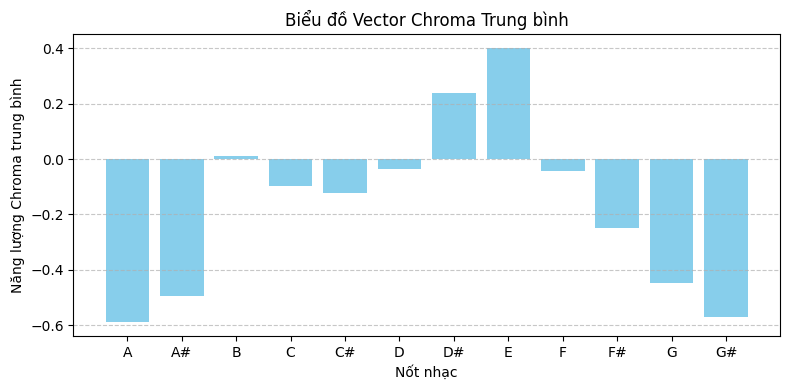

In [8]:
# Chạy thử với file âm thanh
file_path = "sound-fixed_Cello_F1-Arioso_in_C_for_Cello_Solo.wav"  # Thay bằng đường dẫn file âm thanh của bạn
test_chroma(file_path)